In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import DataFrame
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy



In [2]:

def Data_intergate(y, pday):
    y = np.array(y)
    y_process = []
    for i in range(y.shape[0]):
        if i + pday < y.shape[0]:
            Tmp_y = np.array([])
            for p in range(pday):
                Tmp_y = np.append(Tmp_y, y[i+p+1])
            y_process.append(Tmp_y)
    y_process = np.array(y_process)
    return y_process

In [3]:
# Assuming 'df' is your DataFrame and the 'Date' column is already in datetime format
data = pd.read_csv("data/TSLA_process.csv")
data['Date'] = pd.to_datetime(data['Date'])
# Filter the DataFrame to include only records after January 1st, 2018
data= data[data['Date'] > '2017-12-31']
data

,Date,Close,MOM_5,MOM_10,MOM_14,STCK,STCD,close_5_sma,close_5_ema,close_10_sma,...,macd_45_25_15,rsi_14,rsi_28,wr_14,wr_28,wr_50,wr_100,cci_14,cci_50,cci_100
0,2018-01-02,21.368668,0.000000,0.000000,0.000000,0.000000,0.000000,21.368668,21.368668,21.368668,...,0.000000,0.000000,0.000000,-14.221371,-14.221371,-14.221371,-14.221371,0.000000,0.000000,0.000000
1,2018-01-03,21.150000,0.000000,0.000000,0.000000,0.000000,0.000000,21.259334,21.237467,21.259334,...,-0.004906,0.000000,0.000000,-56.140329,-56.140329,-56.140329,-56.140329,66.666667,66.666667,66.666667
2,2018-01-04,20.974667,0.000000,0.000000,0.000000,0.000000,0.000000,21.164445,21.112983,21.164445,...,-0.011688,0.000000,0.000000,-54.317817,-54.317817,-54.317817,-54.317817,-100.000000,-100.000000,-100.000000
3,2018-01-05,21.105333,0.000000,0.000000,0.000000,0.000000,0.000000,21.149667,21.109805,21.149667,...,-0.009769,27.107971,25.973986,-44.302518,-44.302518,-44.302518,-44.302518,-32.272842,-32.272842,-32.272842
4,2018-01-08,22.427334,0.000000,0.000000,0.000000,0.000000,0.000000,21.405200,21.615586,21.405200,...,0.044085,81.563100,80.128434,-1.946364,-1.946364,-1.946364,-1.946364,161.635945,161.635945,161.635945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1577,2024-04-10,171.759995,3.379990,-5.910003,-3.900009,47.388364,56.290371,171.525998,172.288693,172.348000,...,-3.535005,45.856141,43.548113,-52.611636,-74.437633,-75.049906,-89.246799,-6.560040,-69.304516,-88.062685
1578,2024-04-11,174.600006,3.490005,-5.229996,1.779999,59.351340,58.565027,172.223999,173.059131,171.825000,...,-3.107128,48.477531,44.907334,-40.648660,-64.092739,-68.751369,-86.532203,9.834233,-61.828807,-84.642709
1579,2024-04-12,171.050003,6.150009,-4.739990,0.220001,44.397665,50.379123,173.454001,172.389421,171.351001,...,-3.019679,45.511363,43.548132,-55.602335,-56.229204,-76.624517,-89.925438,-18.526388,-68.014469,-86.079047
1580,2024-04-15,161.479996,-11.500000,-13.740005,-11.150009,4.085934,35.944980,171.154001,168.752946,169.977001,...,-3.680172,38.646476,40.150793,-95.914066,-95.914066,-97.848745,-99.072834,-133.862469,-112.860782,-101.627330


In [4]:
next_days = 1
# Load Data

X_train = data[(data['Date'] > '2017-12-31')& (data['Date'] < '2023-01-01')]
X_train

,Date,Close,MOM_5,MOM_10,MOM_14,STCK,STCD,close_5_sma,close_5_ema,close_10_sma,...,macd_45_25_15,rsi_14,rsi_28,wr_14,wr_28,wr_50,wr_100,cci_14,cci_50,cci_100
0,2018-01-02,21.368668,0.000000,0.000000,0.000000,0.000000,0.000000,21.368668,21.368668,21.368668,...,0.000000,0.000000,0.000000,-14.221371,-14.221371,-14.221371,-14.221371,0.000000,0.000000,0.000000
1,2018-01-03,21.150000,0.000000,0.000000,0.000000,0.000000,0.000000,21.259334,21.237467,21.259334,...,-0.004906,0.000000,0.000000,-56.140329,-56.140329,-56.140329,-56.140329,66.666667,66.666667,66.666667
2,2018-01-04,20.974667,0.000000,0.000000,0.000000,0.000000,0.000000,21.164445,21.112983,21.164445,...,-0.011688,0.000000,0.000000,-54.317817,-54.317817,-54.317817,-54.317817,-100.000000,-100.000000,-100.000000
3,2018-01-05,21.105333,0.000000,0.000000,0.000000,0.000000,0.000000,21.149667,21.109805,21.149667,...,-0.009769,27.107971,25.973986,-44.302518,-44.302518,-44.302518,-44.302518,-32.272842,-32.272842,-32.272842
4,2018-01-08,22.427334,0.000000,0.000000,0.000000,0.000000,0.000000,21.405200,21.615586,21.405200,...,0.044085,81.563100,80.128434,-1.946364,-1.946364,-1.946364,-1.946364,161.635945,161.635945,161.635945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,2022-12-23,123.150002,-27.079994,-55.900001,-59.299995,3.400934,3.553951,134.748001,133.682446,146.721001,...,-17.244768,19.819924,28.777794,-96.599066,-97.330821,-98.169784,-98.900056,-145.701825,-202.095316,-154.484319
1255,2022-12-27,109.099998,-40.769997,-58.720009,-70.720009,0.461074,2.779871,126.594002,125.488297,140.849000,...,-19.072995,16.564126,26.425724,-99.538926,-99.622897,-99.735700,-99.834879,-158.019867,-222.353298,-167.374557
1256,2022-12-28,112.709999,-25.090004,-48.239998,-61.329994,6.019393,3.293800,121.576001,121.228864,136.025000,...,-20.000032,20.191722,27.993873,-93.980607,-95.070577,-96.539175,-97.834582,-128.234456,-208.780889,-163.807645
1257,2022-12-29,121.820000,-15.750007,-34.980003,-51.620002,18.287102,8.255856,118.425999,121.425909,132.527000,...,-19.771700,28.625202,31.798073,-81.712898,-85.024259,-89.485907,-93.421391,-82.891079,-173.467434,-148.892811


In [5]:
data1 = pd.read_csv("data/TSLA_process.csv")
y_train = Data_intergate(data1['Close'][0:1260], next_days)
y_train

array([[ 21.15    ],
       [ 20.974667],
       [ 21.105333],
       ...,
       [121.82    ],
       [123.18    ],
       [108.099998]])

In [6]:
len(y_train)

1259

In [7]:
X_test = data1[1259:1580]
X_test

,Date,Close,MOM_5,MOM_10,MOM_14,STCK,STCD,close_5_sma,close_5_ema,close_10_sma,...,macd_45_25_15,rsi_14,rsi_28,wr_14,wr_28,wr_50,wr_100,cci_14,cci_50,cci_100
1259,2023-01-03,108.099998,-15.050004,-42.129998,-59.720009,4.914073,14.937545,114.981999,117.373737,124.865000,...,-19.840796,24.858748,29.590894,-95.085927,-96.330082,-97.393794,-98.352591,-99.789674,-177.989902,-156.887648
1260,2023-01-04,113.639999,4.540001,-36.229996,-47.309998,15.795017,14.106850,115.889999,116.129158,121.242000,...,-19.628578,29.497492,31.807717,-84.204983,-90.453967,-93.220849,-95.714830,-83.811858,-162.262414,-151.696454
1261,2023-01-05,110.339996,-2.370003,-27.460007,-46.460007,10.115344,10.274811,115.415999,114.199437,118.496000,...,-19.501870,28.373846,31.200886,-89.884656,-93.954182,-95.706540,-97.286060,-85.527537,-156.566429,-151.403135
1262,2023-01-06,113.059998,-8.760002,-24.510009,-44.610000,19.009798,14.973386,113.663998,113.819624,116.044999,...,-18.963374,30.716529,32.304817,-80.990202,-88.415199,-91.702928,-94.714753,-79.395973,-147.167398,-148.471900
1263,2023-01-09,119.769997,-3.410003,-5.580001,-30.459999,33.607781,20.910975,112.981998,115.803082,115.486999,...,-17.790098,36.255423,34.974092,-66.392219,-81.505510,-86.754186,-91.527902,-14.502006,-116.171395,-131.961966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1575,2024-04-08,172.979996,-2.240005,2.149994,-0.820007,52.527373,38.360227,168.800000,170.389560,172.514000,...,-4.469799,46.609577,43.644649,-47.472627,-72.158967,-72.344205,-88.080673,-10.987316,-77.255762,-92.739927
1576,2024-04-09,176.880005,10.250000,4.250000,5.559998,68.955377,46.658246,170.850000,172.553042,172.939000,...,-3.740549,50.125470,45.499575,-31.044623,-63.435317,-63.694819,-84.352888,60.289544,-46.134807,-80.637997
1577,2024-04-10,171.759995,3.379990,-5.910003,-3.900009,47.388364,56.290371,171.525998,172.288693,172.348000,...,-3.535005,45.856141,43.548113,-52.611636,-74.437633,-75.049906,-89.246799,-6.560040,-69.304516,-88.062685
1578,2024-04-11,174.600006,3.490005,-5.229996,1.779999,59.351340,58.565027,172.223999,173.059131,171.825000,...,-3.107128,48.477531,44.907334,-40.648660,-64.092739,-68.751369,-86.532203,9.834233,-61.828807,-84.642709


In [8]:
y_test = Data_intergate(data1['Close'][1259:1581], next_days)
y_test

array([[113.639999],
       [110.339996],
       [113.059998],
       [119.769997],
       [118.849998],
       [123.220001],
       [123.559998],
       [122.400002],
       [131.490005],
       [128.779999],
       [127.169998],
       [133.419998],
       [143.75    ],
       [143.889999],
       [144.429993],
       [160.270004],
       [177.899994],
       [166.660004],
       [173.220001],
       [181.410004],
       [188.270004],
       [189.979996],
       [194.759995],
       [196.809998],
       [201.289993],
       [207.320007],
       [196.889999],
       [194.639999],
       [209.25    ],
       [214.240005],
       [202.039993],
       [208.309998],
       [197.369995],
       [200.860001],
       [202.070007],
       [196.880005],
       [207.630005],
       [205.710007],
       [202.770004],
       [190.899994],
       [197.789993],
       [193.809998],
       [187.710007],
       [182.      ],
       [172.919998],
       [173.440002],
       [174.479996],
       [183.2

In [9]:
len(y_test)

321

In [10]:

X_train.to_csv('./FE results/Train_original.csv')
Train_date = X_train['Date']
X_train = X_train.drop(columns=['Date'])


X_test.to_csv('./FE results/Test_original.csv')
Test_date = X_test['Date']
X_test = X_test.drop(columns=['Date'])

y_train = DataFrame(y_train)
y_train.to_csv('./FE results/y_train.csv')
y_test = DataFrame(y_test)
y_test.to_csv('./FE results/y_test.csv')
print('Original number of features: ', data.shape[1])

Original number of features:  32


In [11]:
# Feature Engineering
# Boruta
print('######Boruta######')
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
rf = RandomForestRegressor(n_jobs=-1, max_depth=5)
feat_selector = BorutaPy(rf, n_estimators='auto')
X_train_boruta = feat_selector.fit_transform(X_train.values, y_train.values)
X_test_boruta = feat_selector.transform(X_test.values)
print('The number of features after Boruta: ', np.sum(feat_selector.support_==True))
print('Remained Feature:')
print(X_train.columns[feat_selector.support_].values)
Train_boruta = DataFrame(X_train_boruta)
Train_boruta.insert(0, 'Date', Train_date.values)
Test_boruta = DataFrame(X_test_boruta)
Test_boruta.insert(0, 'Date', Test_date.values)
Train_boruta.to_csv('./FE results/Train_boruta.csv')
Test_boruta.to_csv('./FE results/Test_boruta.csv')



######Boruta######


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConve

The number of features after Boruta:  22
Remained Feature:
['Close' 'MOM_10' 'MOM_14' 'close_5_sma' 'close_5_ema' 'close_10_sma'
 'close_10_ema' 'close_14_sma' 'close_14_ema' 'close_30_sma'
 'close_30_ema' 'close_50_sma' 'close_50_ema' 'close_100_sma'
 'close_100_ema' 'close_200_sma' 'close_200_ema' 'rsi_28' 'wr_14' 'wr_100'
 'cci_14' 'cci_100']


#########PCA#########
The number of features after PCA:  5


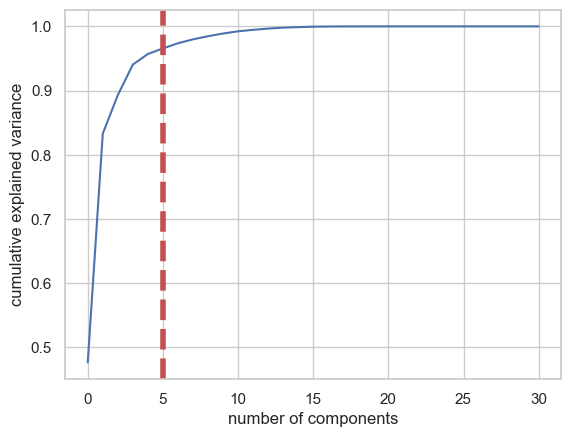

   Cumulative Variance Ratio  Explained Variance Ratio
0                   0.476350                  0.476350
1                   0.832800                  0.356449
2                   0.892951                  0.060151
3                   0.940422                  0.047471
4                   0.956977                  0.016556
#########t-SNE#########
The number of features after t-SNE:  3
KL divergence:  0.19278894364833832


In [12]:
# PCA
print("#########PCA#########")
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.fit_transform(X_test)
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
print('The number of features after PCA: ', pca.n_components_)
Train_pca = DataFrame(X_train_pca)
Train_pca.insert(0, 'Date', Train_date.values)
Test_pca = DataFrame(X_test_pca)
Test_pca.insert(0, 'Date', Test_date.values)
Train_pca.to_csv('./FE results/Train_pca.csv')
Test_pca.to_csv('./FE results/Test_pca.csv')
# plot
pca_all = PCA(n_components=31)
pca_all.fit(X_train_scaled)
evr = pca_all.explained_variance_ratio_
cvr = np.cumsum(evr)
sns.set(style='whitegrid')
plt.plot(cvr)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle='--', x=pca.n_components_, ymin=0, ymax=1)
plt.show()
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
print(pca_df.head(pca.n_components_))

# t-SNE
print("#########t-SNE#########")
from sklearn.manifold import TSNE
tsne = TSNE(n_components=3)
X_train_tsne = tsne.fit_transform(X_train)
X_test_tsne = tsne.fit_transform(X_test)
print('The number of features after t-SNE: ', X_train_tsne.shape[1])
print('KL divergence: ', tsne.kl_divergence_)
Train_tsne = DataFrame(X_train_tsne)
Train_tsne.insert(0, 'Date', Train_date.values)
Test_tsne = DataFrame(X_test_tsne)
Test_tsne.insert(0, 'Date', Test_date.values)
Train_tsne.to_csv('./FE results/Train_tsne.csv')
Test_tsne.to_csv('./FE results/Test_tsne.csv')

